In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from scipy import ndimage
from PIL import ImagePath 
import tensorflow as tf
import os
import cv2
import zipfile
import random

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
#Add augmented images to a directory

# path to animals directory
path = './animalsSubset'

for _, dirs, _  in os.walk(path):
    for animal in dirs:

        # path to current animals dir
        path2 = f'{path}/{animal}'
        print(path2)

        for _, _, files in os.walk(path2):
            for file in files:

                # ignore non-image files
                if file.endswith('.png'):

                    img = cv2.imread(f'{path2}/{file}')
                    if img.shape == (128,128,3):
                        flipped = cv2.flip(img, 1) 
                        rotated = ndimage.rotate(img, 45)
                        # save flipped and rotated to the same folder as the animal
                        cv2.imwrite(f'{path2}/flipped{file}.png', flipped)
                        cv2.imwrite(f'{path2}/rotated{file}.png', rotated)

./animalsSubset3/panda
./animalsSubset3/shark
./animalsSubset3/starfish
./animalsSubset3/tiger


In [3]:
batch_size = 32
img_height, img_width = 128, 128
class_names = ['panda', 'shark', 'starfish', 'tiger']

train_ds = tf.keras.utils.image_dataset_from_directory(directory="animalsSubset3", labels='inferred', validation_split=0.15, subset="training", seed=123, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(directory="animalsSubset3", labels='inferred', validation_split=0.15, subset="validation", seed=123, image_size=(img_height, img_width), batch_size=batch_size)

Found 1200 files belonging to 4 classes.
Using 1020 files for training.
Found 1200 files belonging to 4 classes.
Using 180 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = layers.Rescaling(1./255)

In [6]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [7]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

In [10]:
epochs=25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25


32/32 [==============================] - 3s 62ms/step - loss: 0.9409 - accuracy: 0.5902 - val_loss: 0.4681 - val_accuracy: 0.8389
Epoch 2/25
32/32 [==============================] - 2s 57ms/step - loss: 0.4007 - accuracy: 0.8657 - val_loss: 0.3608 - val_accuracy: 0.8778
Epoch 3/25
32/32 [==============================] - 2s 55ms/step - loss: 0.2667 - accuracy: 0.9049 - val_loss: 0.2336 - val_accuracy: 0.9056
Epoch 4/25
32/32 [==============================] - 2s 56ms/step - loss: 0.1009 - accuracy: 0.9647 - val_loss: 0.2546 - val_accuracy: 0.9333
Epoch 5/25
32/32 [==============================] - 2s 60ms/step - loss: 0.0499 - accuracy: 0.9902 - val_loss: 0.2343 - val_accuracy: 0.9000
Epoch 6/25
32/32 [==============================] - 2s 56ms/step - loss: 0.0869 - accuracy: 0.9686 - val_loss: 0.2977 - val_accuracy: 0.9111
Epoch 7/25
32/32 [==============================] - 2s 54ms/step - loss: 0.0339 - accuracy: 0.9961 - val_loss: 0.2190 - val_accuracy: 0.9444
Epoch 8/25


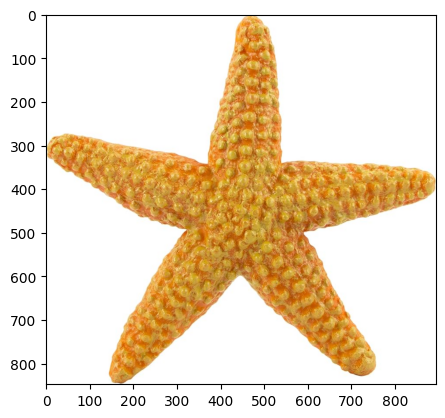

In [15]:
imgPath = "starfish2.jpg"
img = mpimg.imread(imgPath) #Replace "image.jpg" with the path of your image
plt.imshow(img)

In [16]:
img = tf.keras.utils.load_img(imgPath, target_size=(img_height, img_width))
img_array = tf.expand_dims(img, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image is most likely a(n) {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 32ms/step
This image is most likely a(n) starfish with a 80.41 percent confidence.
